<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-subgraph" data-toc-modified-id="Get-subgraph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get subgraph</a></span><ul class="toc-item"><li><span><a href="#Funcs" data-toc-modified-id="Funcs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Funcs</a></span></li><li><span><a href="#Draw-and-analyze-subgraph" data-toc-modified-id="Draw-and-analyze-subgraph-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Draw and analyze subgraph</a></span><ul class="toc-item"><li><span><a href="#Start-Libvis" data-toc-modified-id="Start-Libvis-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Start Libvis</a></span></li><li><span><a href="#Draw-subgraph" data-toc-modified-id="Draw-subgraph-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Draw subgraph</a></span></li></ul></li><li><span><a href="#Energy-contribution-circuit" data-toc-modified-id="Energy-contribution-circuit-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Energy contribution circuit</a></span></li><li><span><a href="#To-tensor-graph" data-toc-modified-id="To-tensor-graph-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>To tensor graph</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path += ['..', './qaoa']
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

import qtree

import utils_qaoa as qu
import utils

# Optional, for live visualisation.
from libvis import Vis

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


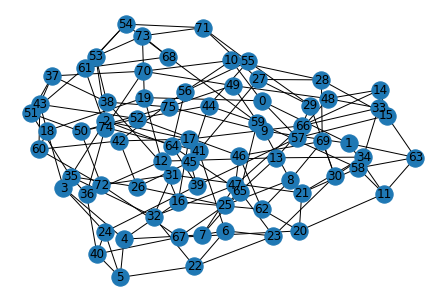

In [22]:
G = qu.get_test_graph(35, type='randomreg', degree=4)
nx.draw(G, with_labels=True)

## Get subgraph

### Funcs


N = 5
C = L_H -- CNot(0,1) -- L_H*

$C = \sum_{edges of G}$

$E = <\gamma, \beta| C | \gamma, \beta>$

$E = \sum_{edge \in ldges of C} <\gamma, \beta| C_{edge} | \gamma, \beta>$


In [23]:
def nodes_at_distance(G, nodes, dist):
    nodes = list(nodes)
    for d in range(dist):
        range_d_nodes = []
        for n in nodes:
            neigh = list(G[n].keys())
            range_d_nodes += neigh
        nodes += range_d_nodes
    return set(nodes)

def get_edge_subgraph(G, edge, dist):
    nodes = nodes_at_distance(G, edge, dist)
    return G.subgraph(set(nodes))

# - Helper funcs
def draw_neighbourhood_of_edge(G, edge, n_size=1):
    nodes = nodes_at_distance(G, edge, n_size)
    cmap = ['red' if n in nodes else 'blue' for n in G]
    nx.draw(G, node_color=cmap, with_labels=True)
    plt.show()
    
def get_degrees_and_max(G):
    degrees = list(zip(*G.degree()))[1]
    return degrees, max(degrees) 
# -

### Draw and analyze subgraph

#### Start Libvis

In [7]:
from libvis.modules import graph as Graph

try:
    vis = Vis(allow_remote=True)
except:
    pass


Started libvis app at http://localhost:7000


#### Draw subgraph

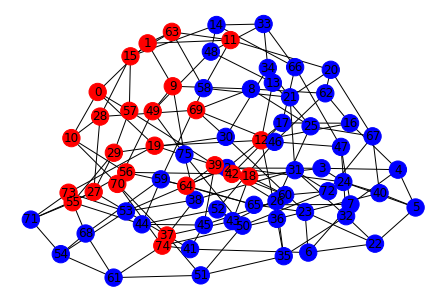

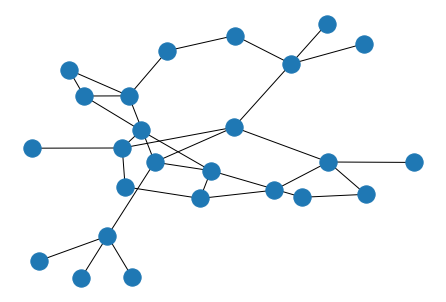

Full graph:76, part graph: 25
Degree of part ((4, 4, 2, 4, 2, 1, 3, 1, 4, 2, 4, 3, 1, 2, 1, 2, 2, 4, 4, 3, 2, 1, 4, 1, 1), 4)
Using edge (0, 10)


In [24]:
p = 2
edges = list(G.edges)
edge = edges[1]

draw_neighbourhood_of_edge(G, edge, n_size=p)
subgraph = G.subgraph(nodes_at_distance(G, edge, p))
nx.draw(subgraph)
plt.show()
print(f'Full graph:{G.number_of_nodes()}, part graph: {subgraph.number_of_nodes()}')
print(f'Degree of part', get_degrees_and_max(subgraph))
print('Using edge', edge)

In [16]:
vis.vars.task_graph = Graph(graph=subgraph)
#vis.show()

In [56]:
vis.stop()

Stopping webapp http server: `Vis.stop_http()`... OK
Stopping websocket server: `Vis.app.stop()`... OK


### Energy contribution circuit

    --mmmmm--
    --.mmm.--
    ----C----
    --.mmm.--
    --mmmmm--
               A
    nodes->    | layers

In [17]:
def get_energy_contrib_circ(G, edge, p):
    subgraph = G.subgraph(nodes_at_distance(G, edge, p))
    beta, gamma = [np.pi/3]*p, [np.pi/2]*p
    G = subgraph
    N = G.number_of_nodes()
    
    mapping = {n:i for n, i in zip(G.nodes, range(N))}
    G = nx.relabel_nodes(G, mapping)
    edge = tuple(mapping[n] for n in edge)
    
    qc = []
    qc += qu.get_qaoa_circuit(G, beta, gamma)
    
    Cost_operator = [[qtree.operators.cZ(*edge)]]
    qc += Cost_operator
    
    qc += qu.get_qaoa_circuit(G, beta, gamma)
    return qc, N

def circ_to_graph(qc, N):
    buck, _,_,_ = qtree.optimizer.circ2buckets(N, qc)
    graph = qtree.graph_model.buckets2graph(buck)
    return graph

def get_energy_contrib_expr(G, edge, p):
    qc, N = get_energy_contrib_circ(G, edge, p)
    return circ_to_graph(qc, N), N
    



In [18]:
G 

In [25]:
p = 2
qc, N = get_energy_contrib_circ(G, edge, p)
print(qc)

[[H(0), H(1), H(2), H(3), H(4), H(5), H(6), H(7), H(8), H(9), H(10), H(11), H(12), H(13), H(14), H(15), H(16), H(17), H(18), H(19), H(20), H(21), H(22), H(23), H(24)], [cX(0,1), ZPhase[alpha=3.14](1), cX(0,1)], [cX(0,3), ZPhase[alpha=3.14](3), cX(0,3)], [cX(0,8), ZPhase[alpha=3.14](8), cX(0,8)], [cX(0,18), ZPhase[alpha=3.14](18), cX(0,18)], [cX(1,4), ZPhase[alpha=3.14](4), cX(1,4)], [cX(1,19), ZPhase[alpha=3.14](19), cX(1,19)], [cX(1,2), ZPhase[alpha=3.14](2), cX(1,2)], [cX(2,15), ZPhase[alpha=3.14](15), cX(2,15)], [cX(3,10), ZPhase[alpha=3.14](10), cX(3,10)], [cX(3,17), ZPhase[alpha=3.14](17), cX(3,17)], [cX(3,22), ZPhase[alpha=3.14](22), cX(3,22)], [cX(4,19), ZPhase[alpha=3.14](19), cX(4,19)], [cX(5,8), ZPhase[alpha=3.14](8), cX(5,8)], [cX(6,18), ZPhase[alpha=3.14](18), cX(6,18)], [cX(6,10), ZPhase[alpha=3.14](10), cX(6,10)], [cX(6,19), ZPhase[alpha=3.14](19), cX(6,19)], [cX(7,8), ZPhase[alpha=3.14](8), cX(7,8)], [cX(8,23), ZPhase[alpha=3.14](23), cX(8,23)], [cX(9,10), ZPhase[alpha=3

### To tensor graph

In [26]:
all_gates = sum(qc, [])
len(all_gates)

723

In [27]:
import tensornetwork as tn
from qtree.operators import M
all_nodes = []
n_qubits = N

tensnet = nx.MultiGraph()

def apply_gate(qubit_gates, gate, operating_qubits):
    _ = tensnet.add_node(hash(gate), 
                         name=gate.name,
                         label=gate.name
                        )
    for i, bit in enumerate(operating_qubits):
        tensnet.add_edge(hash(qubit_gates[bit]), hash(gate))
        #tn.connect(qubit_edges[bit], op[i])
        qubit_gates[bit] = gate
        
qubit_gates = [ M(i) for i in range(n_qubits) ]
_ = [ tensnet.add_node(hash(g)) for g in qubit_gates ]

for layer in qc:
    for gate in layer:
        qubits = gate.qubits
        apply_gate(qubit_gates, gate, qubits)
    
print('nodes', tensnet.number_of_nodes() ) 

nodes 748


In [29]:

vis.vars.tensnet = Graph(tensnet)#nx.convert_node_labels_to_integers(tensnet))

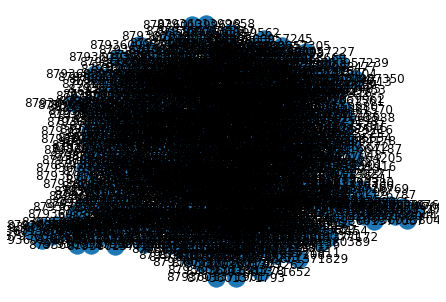

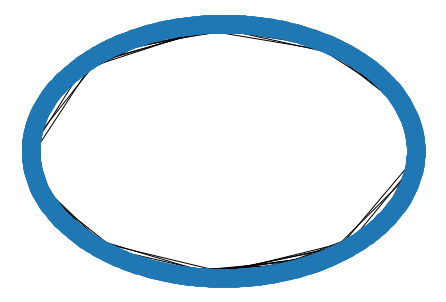

In [30]:
nx.draw_kamada_kawai(tensnet, with_labels=True)
plt.show()
nx.draw_circular(tensnet)

In [54]:
ciq = qtree.baseline_sims.cirq.parse_circuit_1d(qc)
ciq

┌──┐              ┌──┐   ┌─────┐              ┌─────┐   ┌─────┐              ┌─────┐   ┌─────┐              ┌─────┐   ┌───┐              ┌───┐   ┌─────┐              ┌─────┐   ┌─────┐              ┌─────┐   ┌────┐              ┌────┐   ┌────┐              ┌────┐   ┌─────┐              ┌─────┐   ┌────┐              ┌────┐   ┌────┐              ┌────┐   ┌───┐              ┌───┐   ┌─────┐              ┌────┐   ┌─────┐              ┌─────┐   ┌───┐   ┌─────────┐   ┌──────────┐   ┌─────┐              ┌───────────────────┐   ┌─────┐              ┌───────────────────┐   ┌────┐              ┌───────────┐   ┌─────┐              ┌────┐   ┌─────┐              ┌────────────┐   ┌────┐   ┌─────────┐   ┌─────────────────┐   ┌────┐              ┌───────────┐   ┌───┐   ┌─────────┐   ┌─────────────────┐   ┌──┐   ┌───────────┐              ┌────┐   ┌───────────┐              ┌─────┐   ┌───┐              ┌──────────┐   ┌───┐   ┌────────────────┐   ┌──────────────────┐   ┌────┐   ┌────────────────────────┐   ┌──────────┐   ┌─────┐   ┌─────────┐   ┌───────────────────────┐   ┌───┐   ┌──────────┐   ┌─────────┐   ┌────┐   ┌───────────┐   ┌─────────┐   ┌────┐   ┌──────────┐   ┌─────────┐   ┌────┐   ┌─────────────────┐   ┌────────────────┐   ┌─────┐   ┌─────────┐   ┌────────────────────────┐   ┌────┐   ┌────────────────┐   ┌──────────┐   ┌─────┐   ┌─────────┐   ┌───────────┐   ┌────┐              ┌──────────┐   ┌───┐   ┌─────────────────┐   ┌─────────────────┐   ┌─────┐   ┌───────────┐   ┌──────────┐   ┌─────┐   ┌─────────┐   ┌───────────────────────┐   ┌───┐   ┌──────────┐   ┌─────────┐   ┌────┐   ┌───────────┐   ┌─────────┐   ┌────┐   ┌──────────┐   ┌─────────┐   ┌────┐   ┌─────────────────┐   ┌───────────────┐   ┌─────┐   ┌─────────┐   ┌───────────────┐   ┌──┐
0: ────H────@─────────────────@──────@────────────────────@─────────@────────────────────@─────────H────────Z^0.094─────H─────────@──────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────@────────@────────────────────@────────H───────Z^0.094───────H──────────────H─────────────────────────────────────────────────────@───────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@──────────────@────────────────────@────────H──────Z^0.094─────H──────────────────────────────────────────────────────────────────@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────────────────@───────@──────────────────────────────@───────H───────Z^0.094─────H────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            │                 │      │                    │         │                    │                                        │                  │                                                                                                                                                                                                                                                    │       

In [28]:
graph = circ_to_graph(qc, N)

n_nodes = graph.number_of_nodes()
print(f'Use {N} qubits, {n_nodes} nodes')
print('Degrees', get_degrees_and_max(graph))

Use 35 qubits, 951 nodes
Degrees ((1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7, 6, 3, 19, 6, 4, 7, 6, 3, 7, 6, 4, 7, 6, 4, 7, 6, 3, 11, 6, 4, 7, 6, 4, 14, 6, 4, 11, 6, 3, 11, 6, 6, 4, 4, 6, 6, 3, 4, 7, 6, 11, 6, 4, 6, 4, 14, 6, 7, 6, 3, 6, 6, 4, 4, 4, 4, 4, 6, 4, 3, 7, 6, 10, 6, 4, 6, 4, 4, 4, 22, 6, 6, 3, 6, 4, 6, 3, 6, 4, 4, 4, 7, 6, 3, 11, 6, 6, 4, 3, 18, 6, 19, 6, 4, 6, 4, 6, 4, 6, 4, 15, 6, 6, 4, 6, 3, 4, 4, 7, 6, 3, 15, 6, 6, 3, 6, 3, 3, 11, 6, 6, 3, 6, 3, 3, 6, 6, 4, 3, 4, 4, 11, 6, 4, 6, 3, 6, 4, 3, 6, 3, 6, 3, 6, 3, 3, 4, 10, 6, 3, 6, 3, 4, 7, 6, 3, 14, 6, 6, 3, 6, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7, 6, 3, 19, 6, 4, 7, 6, 3, 7, 6, 4, 7, 6, 4, 7

In [37]:
vis.vars.exp_graph = Graph(graph=graph)

192.168.0.17 - - [18/Jun/2020 01:25:27] "GET / HTTP/1.1" 200 -
----------------------------------------
Exception happened during processing of request from ('192.168.0.17', 52234)
Traceback (most recent call last):
  File "/home/dali/side-projects-hobby/pywebviz/python/libvis/http_server.py", line 47, in do_GET
    self.wfile.write(page)
  File "/usr/lib/python3.8/socketserver.py", line 799, in write
    self._sock.sendall(b)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketser

sending value to front:  graph {"directed": false, "multigraph": true, "graph": {}, "nodes": [{"name": "o_0", "size": 2, "id": 0}, {"name": "v_35", "size": 2, "id": 35}, {"name": "o_1", "size": 2, "id": 1}, {"name": "v_36", "size": 2, "id": 36}, {"name": "o_2", "size": 2, "id": 2}, {"name": "v_37", "size": 2, "id": 37}, {"name": "o_3", "size": 2, "id": 3}, {"name": "v_38", "size": 2, "id": 38}, {"name": "o_4", "size": 2, "id": 4}, {"name": "v_39", "size": 2, "id": 39}, {"name": "o_5", "size": 2, "id": 5}, {"name": "v_40", "size": 2, "id": 40}, {"name": "o_6", "size": 2, "id": 6}, {"name": "v_41", "size": 2, "id": 41}, {"name": "o_7", "size": 2, "id": 7}, {"name": "v_42", "size": 2, "id": 42}, {"name": "o_8", "size": 2, "id": 8}, {"name": "v_43", "size": 2, "id": 43}, {"name": "o_9", "size": 2, "id": 9}, {"name": "v_44", "size": 2, "id": 44}, {"name": "o_10", "size": 2, "id": 10}, {"name": "v_45", "size": 2, "id": 45}, {"name": "o_11", "size": 2, "id": 11}, {"name": "v_46", "size": 2, "

In [49]:
nodes_by_degree = sorted(graph.degree, key=lambda x: x[1], reverse=True)

worst_node, worst_degree = nodes_by_degree[0]
print(worst_node, worst_degree)
graph[worst_node]

111 22


AdjacencyView({109: {0: {'tensor': {'name': 'cX', 'indices': (111, 109, 192), 'data_key': 4545567996469958968}}}, 192: {0: {'tensor': {'name': 'cX', 'indices': (111, 109, 192), 'data_key': 4545567996469958968}}, 1: {'tensor': {'name': 'cX', 'indices': (111, 192, 193), 'data_key': 4545567996469958968}}}, 110: {0: {'tensor': {'name': 'H', 'indices': (110, 111), 'data_key': 2135509673891318506}}}, 175: {0: {'tensor': {'name': 'cX', 'indices': (111, 175, 184), 'data_key': 4545567996469958968}}}, 184: {0: {'tensor': {'name': 'cX', 'indices': (111, 175, 184), 'data_key': 4545567996469958968}}, 1: {'tensor': {'name': 'cX', 'indices': (111, 184, 185), 'data_key': 4545567996469958968}}}, 185: {0: {'tensor': {'name': 'cX', 'indices': (111, 184, 185), 'data_key': 4545567996469958968}}}, 147: {0: {'tensor': {'name': 'cX', 'indices': (111, 147, 186), 'data_key': 4545567996469958968}}}, 186: {0: {'tensor': {'name': 'cX', 'indices': (111, 147, 186), 'data_key': 4545567996469958968}}, 1: {'tensor': {'

In [39]:
p = 2
widths = []
neighbourhood_sizes = []

for edge in G.edges:
    graph, N = get_energy_contrib_expr(G, edge, p)
    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    tw = max(nghs)
    widths.append(tw)
    neighbourhood_sizes.append(N)

KeyboardInterrupt: 

[38, 50, 38, 42, 36, 33, 40, 29, 47, 45, 52, 51, 40, 42, 29, 49, 41, 31, 37, 27, 34, 31, 47, 30, 34, 27, 34, 35, 38, 35, 38, 35, 39, 40, 38, 47, 29, 53, 41, 31, 47, 46, 38, 43, 32, 39, 35, 32, 48, 41, 40, 43, 38, 35, 34, 42, 43, 47, 42, 45, 34, 37, 29, 35, 34, 41, 33, 47, 41, 42, 48, 49, 32, 57, 42, 55, 48, 46, 33, 54, 45, 38, 40, 41, 38, 49, 41, 36, 28, 34, 36, 27, 28, 41, 47, 39, 36, 31, 49, 23, 28, 36, 33, 20, 26, 47, 35, 55, 36, 34, 45, 50, 49, 42, 46, 37, 52, 35, 32, 43, 43, 35, 41, 32, 39, 44, 46, 43, 38, 33, 43, 45, 44, 46, 33, 38, 40, 48, 34, 33]


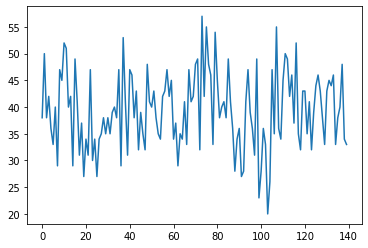

In [32]:
print(widths)
plt.plot(widths)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
 worst edge: (18, 45), worst graph nodes: 951 worst index: 73


/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


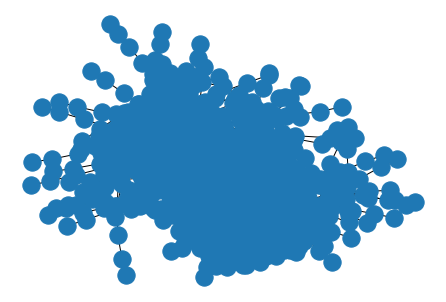

In [33]:
worst_tw_index = np.argmax(widths)
worst_edge = list(G.edges)[worst_tw_index]
worst_graph, worst_N = get_energy_contrib_expr(G, worst_edge, p)
print(f' worst edge: {worst_edge},'
      f' worst graph nodes: {worst_graph.number_of_nodes()}'
      f' worst index: {worst_tw_index}'
     )
nx.draw(worst_graph)

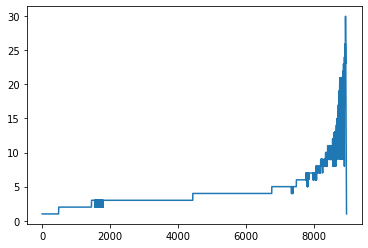

In [15]:
plt.plot(nghs)

In [106]:
mems, flops = qu.cost_graph_peo(graph, peo)

100%|██████████| 286/286 [00:01<00:00, 220.70it/s]


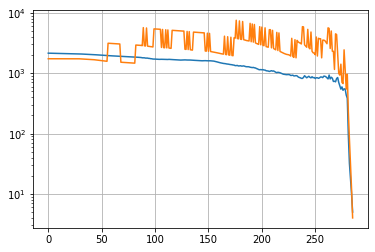

In [107]:
plt.plot(mems)
plt.plot(flops)
plt.yscale('log')
plt.grid()

In [108]:
cone_cost = max(mems), sum(flops)
cones = G.number_of_edges()
tot_cost = max(mems), sum(flops)*cones

print(f'One lightcone {cone_cost[0]} Mem {cone_cost[1]:2.2e} flop')
print(f'All {cones} lightcones {tot_cost[0]} Mem {tot_cost[1]:2.2e} flop')

One lightcone 2142 Mem 8.36e+05 flop
All 93750 lightcones 2142 Mem 7.84e+10 flop


In [46]:
from libvis import Vis
vis = Vis()


2020-06-16 01:13:27.536 | INFO     | legimens.websocket.server:start_server:33 - Starting ws server at localhost:7700


Started libvis app at http://localhost:7000


In [47]:
vis.vars.e = 2


127.0.0.1 - - [16/Jun/2020 01:14:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Jun/2020 01:14:12] "GET /index.bundle.js?2e71a49fef52790323ca HTTP/1.1" 200 -
2020-06-16 01:14:13.101 | INFO     | legimens.App:_ws_conn_handler:81 - New ws connection to / from ::1
2020-06-16 01:14:13.102 | INFO     | legimens.App:_ws_conn_handler:93 - Sending root Legi_0x7f12612c0d10
2020-06-16 01:14:13.120 | INFO     | legimens.App:_ws_conn_handler:81 - New ws connection to /undefined from ::1
2020-06-16 01:14:13.122 | ERROR    | legimens.App:_handle_obj_ref:110 - No child with ref undefined
2020-06-16 01:14:13.766 | INFO     | legimens.App:_ws_conn_handler:81 - New ws connection to /Legi_0x7f12612c0d10 from ::1
2020-06-16 01:14:13.768 | INFO     | legimens.App:_handle_obj_ref:119 - Yield initial update {"e": {"value": 2, "type": "raw"}}
127.0.0.1 - - [16/Jun/2020 01:14:13] "GET /favicon.ico HTTP/1.1" 200 -
2020-06-16 13:57:41.367 | WARNING  | legimens.App:_ws_conn_handler:100 - Connection from ::1 to /Leg